This tutorial demonstrates a basic usage of the image formation pipeline in `cryojax`.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

First, import the `cryojax` simulator. We will import this with the import hooks from `jaxtyping`, which will give our functions run-time type checking capability. See [here](https://docs.kidger.site/jaxtyping/api/runtime-type-checking/#runtime-type-checking) to learn more.

In [3]:
# CryoJAX imports
from jaxtyping import install_import_hook


with install_import_hook("cryojax", "typeguard.typechecked"):
    import cryojax.simulator as cxs

First we must read in our 3D scattering potential into a given voxel-based representation of the `potential`. Here, this is the `FourierVoxelGridPotential`. Then, the representation of a biological specimen is instantiated, which also includes a pose and conformational heterogeneity. Here, the `SingleStructureEnsemble` class is used, which does not model heterogeneity.

In [4]:
from cryojax.io import read_array_with_spacing_from_mrc


# Scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# Read template into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# ... now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-5.0,
)
# ... now, build the ensemble. In this case, the ensemble is just one potential and a
# pose
structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

To see how the array stored in `filename` was written, see the documentation [here](https://mjo22.github.io/cryojax/examples/compute-potential/).

Next, build the *scattering theory*. The simplest `scattering_theory` is the `WeakPhaseScatteringTheory`. This represents the usual image formation pipeline in cryo-EM, which forms images by integrating the potential and convolving the result with a contrast transfer function.

In [5]:
from cryojax.image import operators as op


# Initialize the scattering theory. First, instantiate fourier slice extraction
potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)
# ... next, the contrast transfer theory
ctf = cxs.ContrastTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
transfer_theory = cxs.ContrastTransferTheory(
    ctf, envelope=op.FourierGaussian(b_factor=5.0)
)
# ... add a non-white noise model for the solvent, choosing the characteristic
# strength to be a fraction of the integrated specimen potential
strength = 0.05 * real_voxel_grid.sum(axis=0).max() * voxel_size
solvent = cxs.GaussianIce(
    variance_function=op.Lorenzian(
        amplitude=strength**2, length_scale=2.0 * potential.voxel_size
    )
)
# ... now for the scattering theory
scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, potential_integrator, transfer_theory, solvent
)

Finally, we create an `InstrumentConfig` and initialize our `AbstractImagingPipeline`. Here, we select the `ContrastImagingPipeline`, which simulates the image contrast given a `scattering_theory`.

In [6]:
# Create the instrument configuration
instrument_config = cxs.InstrumentConfig(
    shape=(80, 80),
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
    padded_shape=potential.shape[:2],
)
# ... now, build the image formation model
imaging_pipeline = cxs.ContrastImagingPipeline(instrument_config, scattering_theory)

Before proceeding, we must create jit-compiled functions that simulate our images. We can either simulate the model without noise by calling the `imaging_pipeline.render()` function, or we can simulate an image with noise by passing a random number generator key as `imaging_pipeline.render(rng_key)`.

In [7]:
import equinox as eqx
from jaxtyping import PRNGKeyArray


@eqx.filter_jit
def compute_image(imaging_pipeline: cxs.AbstractImagingPipeline):
    """Simulate an image without noise from a `imaging_pipeline`."""
    return imaging_pipeline.render()


@eqx.filter_jit
def compute_noisy_image(imaging_pipeline: cxs.AbstractImagingPipeline, key: PRNGKeyArray):
    """Simulate an image with noise from a `imaging_pipeline`."""
    return imaging_pipeline.render(key)

**What's with the eqx.filter_jit?**

This is an example of an equinox *filtered transformation*. In this case, the `eqx.filter_jit` decorator is a lightweight wrapper around `jax.jit` that treats all of the `imaging_pipeline`'s JAX arrays as traced at compile time, and all of its non-JAX arrays as static. Alternatively, we could have used the usual `jax.jit` decorator and explicitly passed traced and static pytrees to our function. It is completely optional to use `equinox` decorators.

Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in the equinox documentation for an introduction.

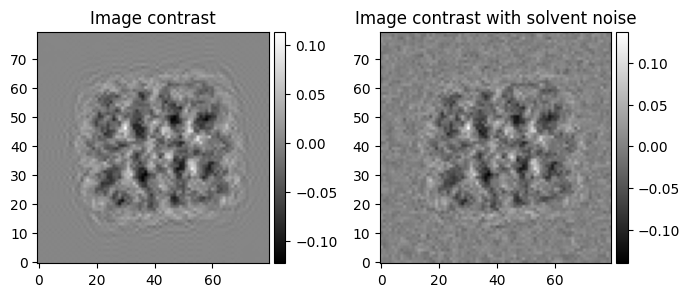

In [8]:
# Simulate each image, drawing from the stochastic parts of the model
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=2, figsize=(7, 4))
ax1, ax2 = axes
im1 = plot_image(
    compute_image(imaging_pipeline),
    fig,
    ax1,
    label="Image contrast",
)
im2 = plot_image(
    compute_noisy_image(imaging_pipeline, key),
    fig,
    ax2,
    label="Image contrast with solvent noise",
)
plt.tight_layout()

Note that the `compute_noisy_image` function draws an image from the noise models contained in the image formation `imaging_pipeline`. These noise models are meant to be physical noise models, so in theory, these do not need to cleanly correspond to sampling from a particular statistical distribution. Alternatively, the user can simulate an image from a specific distribution from the `cryojax.inference.distributions` module. In this example, we use the `IndependentGaussianFourierModes` distribution, which simulates images from an arbitrary noise power spectrum.

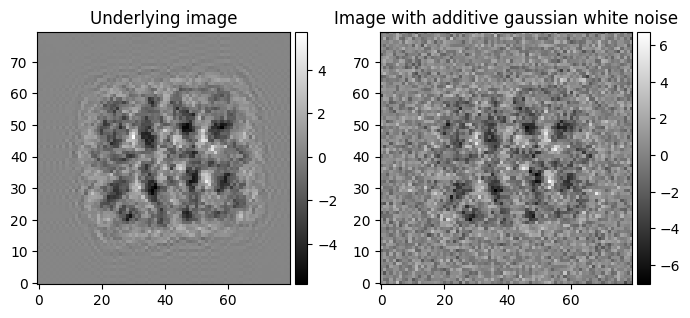

In [9]:
import jax.numpy as jnp

from cryojax.image import operators as op
from cryojax.inference import distributions as dist


@eqx.filter_jit
def compute_image_with_distribution(distribution: dist.AbstractDistribution):
    """Simulate an image with noise from a `imaging_pipeline`."""
    return distribution.compute_signal()


@eqx.filter_jit
def compute_noisy_image_with_distribution(
    distribution: dist.AbstractDistribution, key: PRNGKeyArray
):
    """Simulate an image with noise from a `imaging_pipeline`."""
    return distribution.sample(key)


# Passing the ImagePipeline and a variance function, instantiate the distribution
distribution = dist.IndependentGaussianFourierModes(
    imaging_pipeline,
    signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
    variance_function=op.Constant(1.0),
)
# ... then, either simulate an image from this distribution
key = jax.random.PRNGKey(seed=0)

fig, axes = plt.subplots(ncols=2, figsize=(7, 4))
ax1, ax2 = axes
im1 = plot_image(
    compute_image_with_distribution(distribution),
    fig,
    ax1,
    label="Underlying image",
)
im2 = plot_image(
    compute_noisy_image_with_distribution(distribution, key),
    fig,
    ax2,
    label="Image with additive gaussian white noise",
)
plt.tight_layout()

Here, we can directly control image SNR through the parameters `distribution.signal_scale_factor` (a phenomenological scale factor for the underlying signal) and `distribution.variance_function` (a function that computes the variance, or power spectrum, of the gaussian noise).

Notice that in order to simulate the image with additive white noise, we chose the power spectrum to be a constant. In particular, we set `variance_function = op.Constant(1.0)`. We can instead use the `cryojax.image.operators` module to build a more complex power spectrum. In this example, we choose the variance to be a lorenzian envelope modulated by the CTF, plus additive white noise.

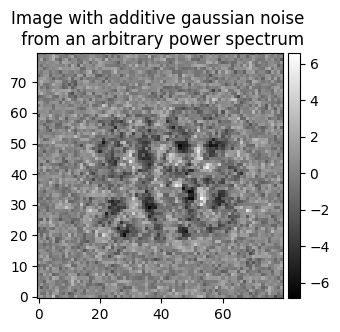

In [10]:
variance_function = op.Constant(0.5) + ctf * ctf * op.Lorenzian(
    amplitude=2.5, length_scale=instrument_config.pixel_size * 5.0
)
# Passing the ImagePipeline and a variance function, instantiate the distribution
non_white_noise_distribution = dist.IndependentGaussianFourierModes(
    imaging_pipeline,
    signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
    variance_function=variance_function,
)
# ... then, either simulate an image from this distribution
key = jax.random.PRNGKey(seed=0)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
im = plot_image(
    compute_noisy_image_with_distribution(non_white_noise_distribution, key),
    fig,
    ax,
    label="Image with additive gaussian noise \n from an arbitrary power spectrum",
)
plt.tight_layout()